In [ ]:
!pip install transformers datasets evaluate matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

import evaluate
from tqdm.auto import tqdm

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

liar.py:   0%|          | 0.00/6.41k [00:00<?, ?B/s]

The repository for liar contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/liar.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset features: {'id': Value(dtype='string', id=None), 'label': ClassLabel(names=['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire'], id=None), 'statement': Value(dtype='string', id=None), 'subject': Value(dtype='string', id=None), 'speaker': Value(dtype='string', id=None), 'job_title': Value(dtype='string', id=None), 'state_info': Value(dtype='string', id=None), 'party_affiliation': Value(dtype='string', id=None), 'barely_true_counts': Value(dtype='float32', id=None), 'false_counts': Value(dtype='float32', id=None), 'half_true_counts': Value(dtype='float32', id=None), 'mostly_true_counts': Value(dtype='float32', id=None), 'pants_on_fire_counts': Value(dtype='float32', id=None), 'context': Value(dtype='string', id=None)}
Number of training examples: 10269
Number of validation examples: 1284
Number of test examples: 1283

Label distribution in training set:
1    2123
0    1998
2    1966
3    1683
4    1657
5     842
Name: count, dtype: int64


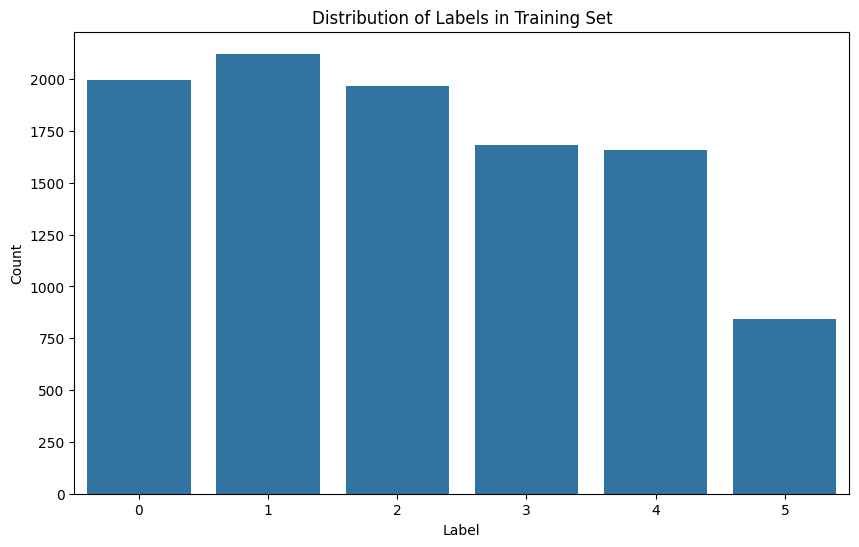


Sample entries from dataset:
Example 1:
Statement: Says the Annies List political group supports third-trimester abortions on demand.
Label: 0
Subject: abortion
------------------------
Example 2:
Statement: When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
Label: 1
Subject: energy,history,job-accomplishments
------------------------
Example 3:
Statement: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
Label: 2
Subject: foreign-policy
------------------------


In [ ]:
# Load the dataset
dataset = load_dataset("liar")

# Display dataset information
print(f"Dataset features: {dataset['train'].features}")
print(f"Number of training examples: {len(dataset['train'])}")
print(f"Number of validation examples: {len(dataset['validation'])}")
print(f"Number of test examples: {len(dataset['test'])}")

# Explore the distribution of labels
train_labels = dataset['train']['label']
label_counts = pd.Series(train_labels).value_counts()
print("\nLabel distribution in training set:")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=train_labels)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Display a few examples
print("\nSample entries from dataset:")
for i in range(3):
    print(f"Example {i+1}:")
    print(f"Statement: {dataset['train'][i]['statement']}")
    print(f"Label: {dataset['train'][i]['label']}")
    print(f"Subject: {dataset['train'][i]['subject']}")
    print("------------------------")

In [ ]:
# Select a pre-trained model
model_name = "distilbert-base-uncased"  # A smaller model for faster training
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to preprocess the data
def preprocess_function(examples):
    return tokenizer(examples["statement"], truncation=True, padding="max_length", max_length=128)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Convert to PyTorch format and select relevant columns
tokenized_dataset = tokenized_dataset.remove_columns(['statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Create dataloaders
batch_size = 16

train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=batch_size)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size)

# Display a batch to verify the preprocessing
batch = next(iter(train_dataloader))
print(f"Input batch shape: {batch['input_ids'].shape}")
print(f"Attention mask batch shape: {batch['attention_mask'].shape}")
print(f"Labels batch shape: {batch['labels'].shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Input batch shape: torch.Size([16, 128])
Attention mask batch shape: torch.Size([16, 128])
Labels batch shape: torch.Size([16])


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


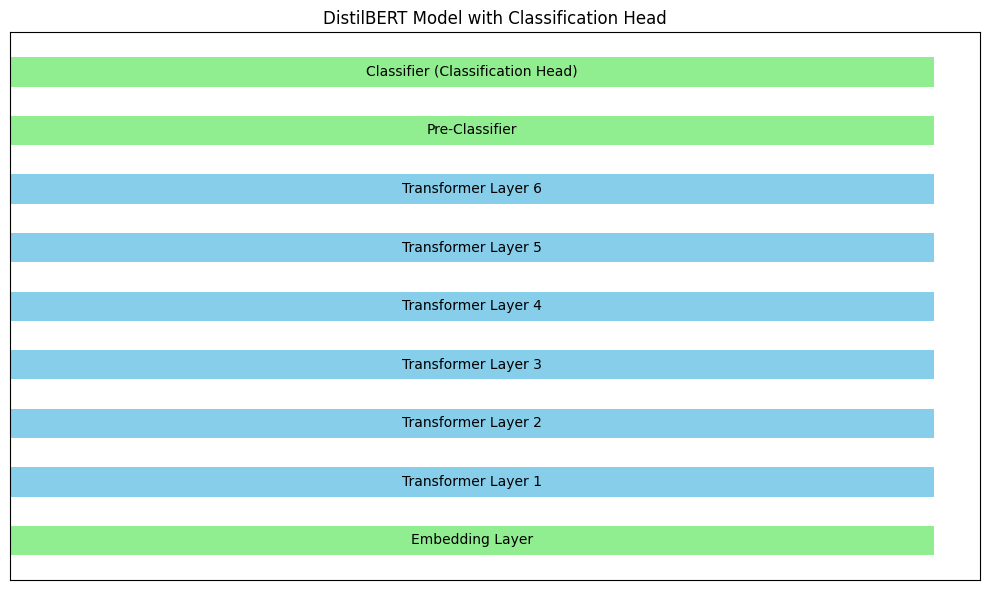

In [ ]:
# Define the number of labels in our dataset
num_labels = 6  # LIAR dataset has 6 classes: pants-fire, false, barely-true, half-true, mostly-true, true

# Load pre-trained model with a classification head
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Examine the model architecture
print(model)

# Create a custom visualization of the model architecture
def visualize_model_architecture(model):
    """Create a simplified visualization of the model architecture"""
    layers = []
    # Extract DistilBERT layers
    layers.append("Embedding Layer")
    for i in range(len(model.distilbert.transformer.layer)):
        layers.append(f"Transformer Layer {i+1}")
    # Add classification head
    layers.append("Pre-Classifier")
    layers.append("Classifier (Classification Head)")

    # Plot
    plt.figure(figsize=(10, 6))
    for i, layer in enumerate(layers):
        plt.barh(i, 0.8, left=0.1, height=0.5, color='skyblue' if 'Transformer' in layer else 'lightgreen')
        plt.text(0.5, i, layer, ha='center', va='center')
    plt.yticks([])
    plt.xticks([])
    plt.title('DistilBERT Model with Classification Head')
    plt.tight_layout()
    plt.show()

visualize_model_architecture(model)

# Task: Implement a custom classifier head
class CustomClassificationHead(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        # TODO: Implement your custom classification head here
        # Hint: Consider using layers like Linear, Dropout, and activation functions
        self.pre_classifier = torch.nn.Linear(input_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = torch.nn.ReLU()

    def forward(self, hidden_states):
        # TODO: Implement the forward pass
        # Process the final hidden states from the transformer
        hidden_states = self.pre_classifier(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)
        return logits

# Replace the classification head with a custom one
# input_dim = model.config.hidden_size  # Usually 768 for DistilBERT
# hidden_dim = 256
# output_dim = num_labels
#
# # Save the model's transformer component
# transformer = model.distilbert
#
# # Create a new model with the custom head
# class CustomModel(torch.nn.Module):
#     def __init__(self, transformer, classification_head):
#         super().__init__()
#         self.transformer = transformer
#         self.classification_head = classification_head
#
#     def forward(self, input_ids, attention_mask):
#         # Get transformer outputs
#         outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_states = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
#         logits = self.classification_head(hidden_states)
#         return logits
#
# custom_head = CustomClassificationHead(input_dim, hidden_dim, output_dim)
# custom_model = CustomModel(transformer, custom_head)
#
# # Print the custom model architecture
# print(custom_model)

Starting fine-tuning...


Training Epoch 1:   0%|          | 0/642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 1.7175, Eval Accuracy: 0.2570


Training Epoch 2:   0%|          | 0/642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 1.5660, Eval Accuracy: 0.2679


Training Epoch 3:   0%|          | 0/642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 1.2110, Eval Accuracy: 0.2804


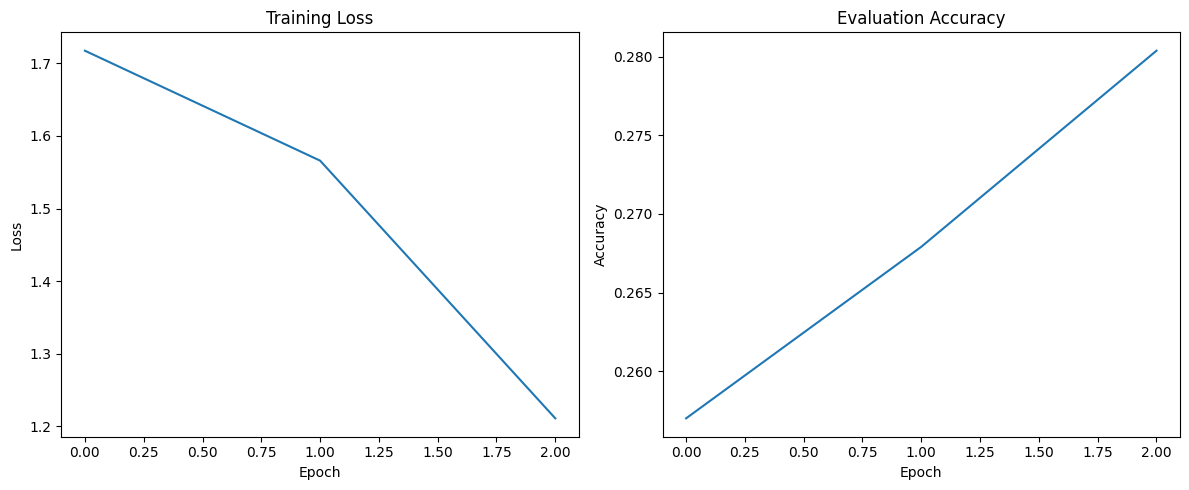

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Implement fine-tuning
def train_and_evaluate(model, train_dataloader, eval_dataloader, num_epochs=3):
    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    # Set up learning rate scheduler
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Define class weights to handle imbalance (optional)
    # Calculate class weights based on the distribution in the training set
    # This is a placeholder - students should implement their own weighting strategy
    class_weights = torch.ones(num_labels).to(device)  # Equal weights for all classes

    # Initialize tracking variables
    train_losses = []
    eval_accuracies = []
    best_accuracy = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}")

        for batch in train_progress_bar:
            # Prepare batch for model
            # Only pass expected arguments to the model (input_ids, attention_mask, labels)
            model_inputs = {}
            if 'input_ids' in batch:
                model_inputs['input_ids'] = batch['input_ids'].to(device)
            if 'attention_mask' in batch:
                model_inputs['attention_mask'] = batch['attention_mask'].to(device)
            if 'labels' in batch:
                model_inputs['labels'] = batch['labels'].to(device)

            # Forward pass
            outputs = model(**model_inputs)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Update progress bar
            total_loss += loss.item()
            train_progress_bar.set_postfix({"loss": total_loss / len(train_progress_bar)})

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation phase
        model.eval()
        all_preds = []
        all_labels = []

        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            # Prepare batch for model
            model_inputs = {}
            if 'input_ids' in batch:
                model_inputs['input_ids'] = batch['input_ids'].to(device)
            if 'attention_mask' in batch:
                model_inputs['attention_mask'] = batch['attention_mask'].to(device)
            if 'labels' in batch:
                model_inputs['labels'] = batch['labels'].to(device)
                labels = batch['labels'].to(device)

            with torch.no_grad():
                outputs = model(**model_inputs)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        eval_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Eval Accuracy: {accuracy:.4f}")

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            # Save model (optional)
            # torch.save(model.state_dict(), "best_model.pt")

    # Plot training progress
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(eval_accuracies)
    plt.title('Evaluation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

    return all_preds, all_labels

# Run training and evaluation
print("Starting fine-tuning...")
predictions, references = train_and_evaluate(model, train_dataloader, eval_dataloader, num_epochs=3)

## Part 5: Performance Analysis

Overall Accuracy: 0.2804

Per-class Performance:
Class 0 - Precision: 0.3225, Recall: 0.3384, F1: 0.3302
Class 1 - Precision: 0.2475, Recall: 0.2984, F1: 0.2706
Class 2 - Precision: 0.2988, Recall: 0.2869, F1: 0.2927
Class 3 - Precision: 0.2624, Recall: 0.3136, F1: 0.2857
Class 4 - Precision: 0.2385, Recall: 0.2194, F1: 0.2286
Class 5 - Precision: 0.4167, Recall: 0.1724, F1: 0.2439


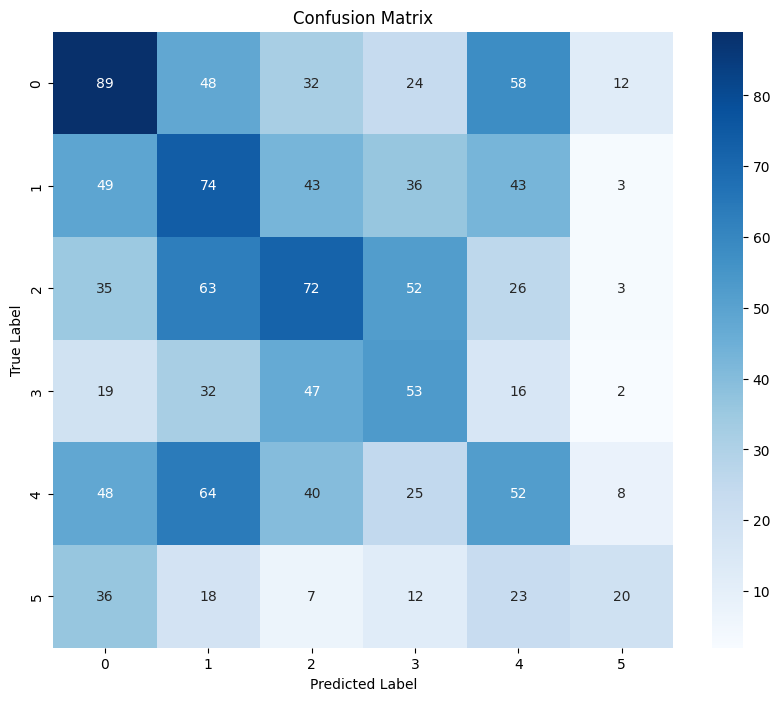

In [ ]:
# Calculate performance metrics
precision, recall, f1, _ = precision_recall_fscore_support(references, predictions, average=None)
accuracy = accuracy_score(references, predictions)

# Display metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nPer-class Performance:")
for i in range(num_labels):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

# Calculate and plot confusion matrix
cm = confusion_matrix(references, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Error analysis: Find examples that were misclassified
def analyze_errors(dataset, tokenized_dataset, predictions, references):
    misclassified_indices = [i for i, (pred, ref) in enumerate(zip(predictions, references)) if pred != ref]
    if len(misclassified_indices) > 5:
        misclassified_indices = misclassified_indices[:5]  # Limit to 5 examples

    print("\nMisclassified Examples:")
    for idx in misclassified_indices:
        true_label = references[idx]
        pred_label = predictions[idx]
        # Find original text
        original_idx = tokenized_dataset['validation'][idx]['idx'] if 'idx' in tokenized_dataset['validation'][idx] else idx
        original_text = dataset['validation'][original_idx]['statement']
        print(f"Example: {original_text}")
        print(f"True label: {true_label}, Predicted label: {pred_label}")
        print("-------------------")

# Run error analysis
# analyze_errors(dataset, tokenized_dataset, predictions, references)

In [ ]:
# Load multilingual model
multilingual_model_name = "xlm-roberta-base"
multilingual_tokenizer = AutoTokenizer.from_pretrained(multilingual_model_name)
multilingual_model = AutoModelForSequenceClassification.from_pretrained(
    multilingual_model_name,
    num_labels=num_labels
)

# Example of tokenizing text in different languages
english_text = "This is fake news."
spanish_text = "Esto es una noticia falsa."
french_text = "C'est une fausse nouvelle."

# Tokenize
tokens_en = multilingual_tokenizer(english_text, return_tensors="pt")
tokens_es = multilingual_tokenizer(spanish_text, return_tensors="pt")
tokens_fr = multilingual_tokenizer(french_text, return_tensors="pt")

print("English tokens:", tokens_en.input_ids)
print("Spanish tokens:", tokens_es.input_ids)
print("French tokens:", tokens_fr.input_ids)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


English tokens: tensor([[     0,   3293,     83, 106287,   7123,      5,      2]])
Spanish tokens: tensor([[    0, 38554,   198,   220, 97362, 75806,     5,     2]])
French tokens: tensor([[    0,   313,    25,   525,   773,  1071, 55870, 24164,     5,     2]])


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


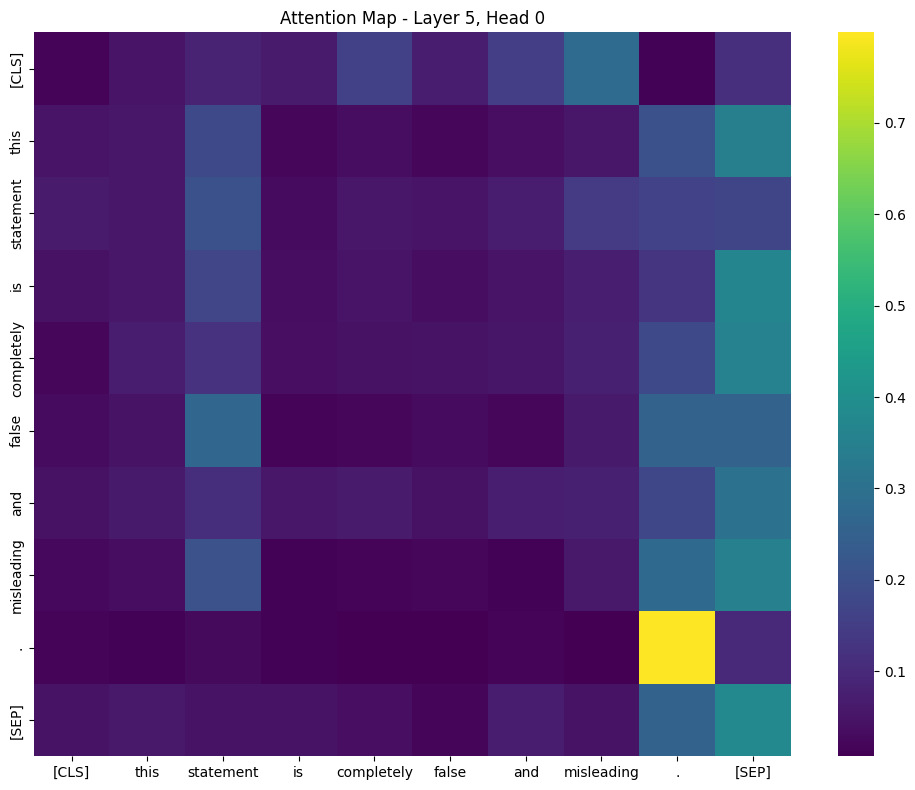

In [ ]:
def visualize_attention(model, tokenizer, text, layer_idx=5, head_idx=0):
    """Visualize attention for a given text"""
    # Tokenize the text
    tokens = tokenizer(text, return_tensors="pt")
    tokens = {k: v.to(device) for k, v in tokens.items()}

    # Get attention weights
    with torch.no_grad():
        outputs = model(**tokens, output_attentions=True)

    attentions = outputs.attentions  # Tuple of attention tensors
    # Extract attention for specific layer and head
    attention = attentions[layer_idx][0, head_idx].cpu().numpy()

    # Get tokens for visualization
    input_ids = tokens["input_ids"][0].cpu().numpy()
    tokens_str = tokenizer.convert_ids_to_tokens(input_ids)

    # Create attention map
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens_str, yticklabels=tokens_str, cmap="viridis")
    plt.title(f"Attention Map - Layer {layer_idx}, Head {head_idx}")
    plt.tight_layout()
    plt.show()

# Example for attention visualization
visualize_attention(model, tokenizer, "This statement is completely false and misleading.")

In [ ]:
# TODO: Implement your chosen class imbalance solution here
# Example: Weighted loss function
def calculate_class_weights(labels):
    """Calculate weights inversely proportional to class frequencies"""
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    weights = total_samples / (len(class_counts) * class_counts)
    return torch.tensor(weights, dtype=torch.float)

# Get training labels
train_labels = [item['labels'].item() for item in tokenized_dataset['train']]
class_weights = calculate_class_weights(train_labels).to(device)

# Use weighted loss in training
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

Dataset features: {'id': Value(dtype='string', id=None), 'label': ClassLabel(names=['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire'], id=None), 'statement': Value(dtype='string', id=None), 'subject': Value(dtype='string', id=None), 'speaker': Value(dtype='string', id=None), 'job_title': Value(dtype='string', id=None), 'state_info': Value(dtype='string', id=None), 'party_affiliation': Value(dtype='string', id=None), 'barely_true_counts': Value(dtype='float32', id=None), 'false_counts': Value(dtype='float32', id=None), 'half_true_counts': Value(dtype='float32', id=None), 'mostly_true_counts': Value(dtype='float32', id=None), 'pants_on_fire_counts': Value(dtype='float32', id=None), 'context': Value(dtype='string', id=None)}
Train: 10269 | Val: 1284 | Test: 1283


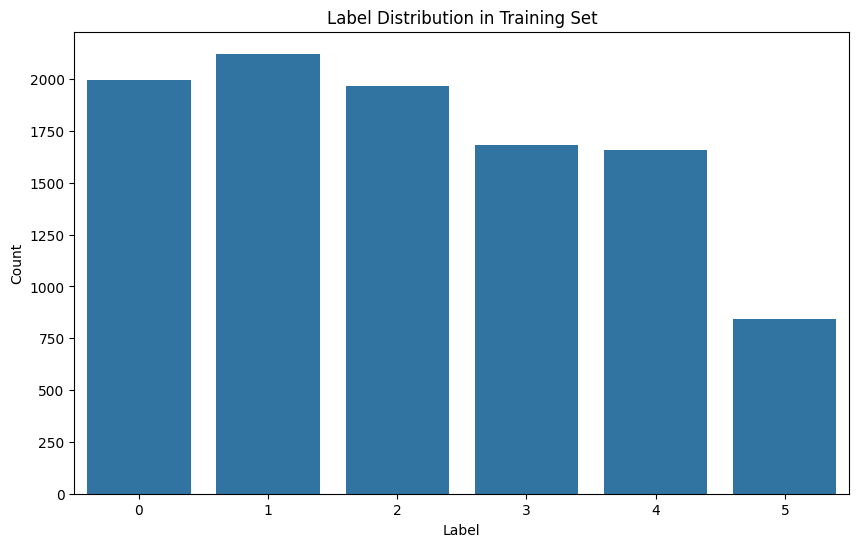

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Training Epoch 1:   0%|          | 0/642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.7184 | Eval Acc: 0.2648


Training Epoch 2:   0%|          | 0/642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.5851 | Eval Acc: 0.2586


Training Epoch 3:   0%|          | 0/642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1.2274 | Eval Acc: 0.2749

 Overall Accuracy: 0.2749
 Per-Class Performance:
Class 0 — Precision: 0.33, Recall: 0.31, F1: 0.32
Class 1 — Precision: 0.24, Recall: 0.32, F1: 0.28
Class 2 — Precision: 0.29, Recall: 0.26, F1: 0.28
Class 3 — Precision: 0.25, Recall: 0.27, F1: 0.26
Class 4 — Precision: 0.23, Recall: 0.24, F1: 0.24
Class 5 — Precision: 0.40, Recall: 0.21, F1: 0.27


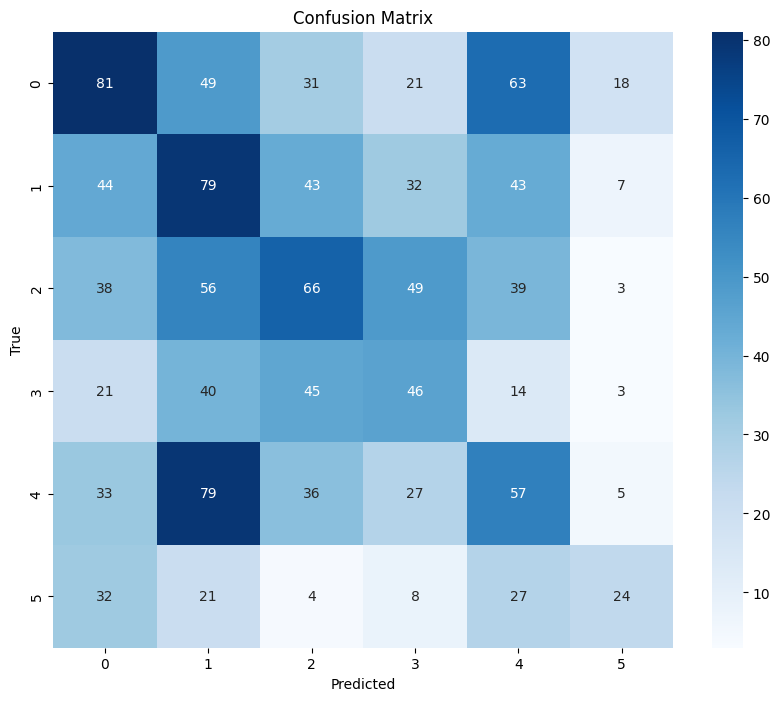

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_scheduler

from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm.auto import tqdm
import evaluate


dataset = load_dataset("liar", trust_remote_code=True)


print(f"Dataset features: {dataset['train'].features}")
print(f"Train: {len(dataset['train'])} | Val: {len(dataset['validation'])} | Test: {len(dataset['test'])}")

plt.figure(figsize=(10, 6))
sns.countplot(x=dataset['train']['label'])
plt.title("Label Distribution in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["statement"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns([
    'statement', 'subject', 'speaker', 'job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts', 'context'
])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


batch_size = 16
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=batch_size)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size)


num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


def train_and_evaluate(model, train_dataloader, eval_dataloader, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    train_losses = []
    eval_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        all_preds, all_labels = [], []
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        eval_accuracies.append(acc)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Eval Acc: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            torch.save(model.state_dict(), "best_model.pt")

    return all_preds, all_labels


print("Starting training...")
predictions, references = train_and_evaluate(model, train_dataloader, eval_dataloader)


precision, recall, f1, _ = precision_recall_fscore_support(references, predictions, average=None)
accuracy = accuracy_score(references, predictions)

print(f"\n Overall Accuracy: {accuracy:.4f}")
print(" Per-Class Performance:")
for i in range(num_labels):
    print(f"Class {i} — Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}")

# Confusion Matrix
cm = confusion_matrix(references, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


def predict_news_statement(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)[0]
    predicted_class = torch.argmax(probs).item()

    label_names = {
        0: "Pants on Fire ",
        1: "False ",
        2: "Barely True ",
        3: "Half True ",
        4: "Mostly True ",
        5: "True "
    }

    print(f"\n Statement: {text}")
    print(f" Prediction: {label_names[predicted_class]}")
    print(" Probabilities:")
    for i, p in enumerate(probs):
        print(f"  - {label_names[i]}: {p.item():.2%}")



In [ ]:
# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)

# Try some test statements
test_statements = [
    "The president said that vaccines cause autism.",
    "NASA announced water was discovered on the moon.",
    "The government gives every citizen $500 monthly.",
    "Eating chocolate helps you lose weight.",
    "COVID-19 is a hoax created by the media.",
    "The Eiffel Tower is located in London."
]

for statement in test_statements:
    predict_news_statement(statement, model, tokenizer, device)


 Statement: The president said that vaccines cause autism.
 Prediction: Pants on Fire 
 Probabilities:
  - Pants on Fire : 39.79%
  - False : 3.33%
  - Barely True : 2.63%
  - Half True : 3.42%
  - Mostly True : 14.11%
  - True : 36.71%

 Statement: NASA announced water was discovered on the moon.
 Prediction: True 
 Probabilities:
  - Pants on Fire : 26.00%
  - False : 7.79%
  - Barely True : 4.64%
  - Half True : 4.22%
  - Mostly True : 24.67%
  - True : 32.68%

 Statement: The government gives every citizen $500 monthly.
 Prediction: Barely True 
 Probabilities:
  - Pants on Fire : 6.89%
  - False : 12.22%
  - Barely True : 44.06%
  - Half True : 26.53%
  - Mostly True : 9.11%
  - True : 1.19%

 Statement: Eating chocolate helps you lose weight.
 Prediction: Mostly True 
 Probabilities:
  - Pants on Fire : 13.45%
  - False : 22.75%
  - Barely True : 15.22%
  - Half True : 10.71%
  - Mostly True : 31.51%
  - True : 6.35%

 Statement: COVID-19 is a hoax created by the media.
 Predict